# binary classification probability calibration
- https://scikit-learn.org/stable/modules/calibration.html#id12

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    brier_score_loss,
    precision_score,
    recall_score,
    f1_score
    )
np.random.seed(0)

## data

In [2]:
X, y = datasets.make_classification(n_samples=100000, n_features=10, n_informative=8, n_redundant=2)

X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.5)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, train_size=0.5)

## model fit

In [3]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

## score

In [4]:
print('>>>> RF')
print("Precision: %0.3f" % precision_score(y_test, y_pred_rfc))
print("Recall: %0.3f" % recall_score(y_test, y_pred_rfc))
print("F1: %0.3f" % f1_score(y_test, y_pred_rfc))
print("Brier score RFC: %0.3f" % brier_score_loss(y_test, model_rfc.predict_proba(X_test)[:, 1]))

print('>>>> LR')
print("Precision: %0.3f" % precision_score(y_test, y_pred_lr))
print("Recall: %0.3f" % recall_score(y_test, y_pred_lr))
print("F1: %0.3f" % f1_score(y_test, y_pred_lr))
print("Brier score LR: %0.3f" % brier_score_loss(y_test, model_lr.predict_proba(X_test)[:, 1]))

>>>> RF
Precision: 0.994
Recall: 0.994
F1: 0.994
Brier score RFC: 0.007
>>>> LR
Precision: 0.939
Recall: 0.952
F1: 0.946
Brier score LR: 0.043


## calibration plot
- RFC is overconfident in its prediction, pushing the probability toward zero and one

In [5]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

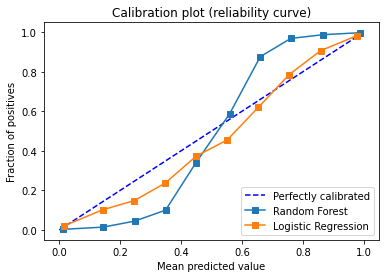

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_rfc = model_rfc.predict_proba(X_test)[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('Random Forest'))

prob_pos_lr = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.show()

## Probability calibration
- Sigmoid scaling or Platt’s method. This is suitable for models with a sigmoid curve (like RFC) and it works well with small datasets.
- Isotonic regression — a non-parametric approach. It is a more powerful calibration method but it tends to overfit and is not advised for small datasets.

In [7]:
from sklearn.calibration import CalibratedClassifierCV

- sigmoid method

In [8]:
sig_calibrator_rfc = CalibratedClassifierCV(model_rfc, cv='prefit', method='sigmoid')
sig_calibrator_rfc.fit(X_valid, y_valid)
sig_y_prob_rfc = sig_calibrator_rfc.predict_proba(X_test)

sig_calibrator_lr = CalibratedClassifierCV(model_lr, cv='prefit', method='sigmoid')
sig_calibrator_lr.fit(X_valid, y_valid)
sig_y_prob_lr = sig_calibrator_lr.predict_proba(X_test)

- Isotonic

In [9]:
iso_calibrator_rfc = CalibratedClassifierCV(model_rfc, cv='prefit', method='isotonic')
iso_calibrator_rfc.fit(X_valid, y_valid)
iso_y_prob_rfc = iso_calibrator_rfc.predict_proba(X_test)

iso_calibrator_lr = CalibratedClassifierCV(model_lr, cv='prefit', method='isotonic')
iso_calibrator_lr.fit(X_valid, y_valid)
iso_y_prob_lr = iso_calibrator_lr.predict_proba(X_test)

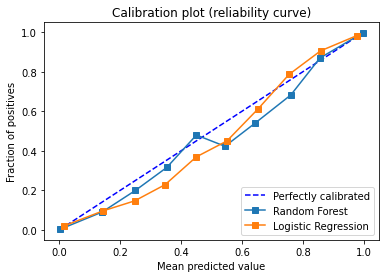

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_rfc = sig_y_prob_rfc[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('Random Forest'))

prob_pos_lr = sig_y_prob_lr[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.show()

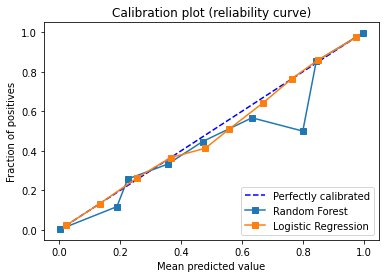

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_rfc = iso_y_prob_rfc[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('Random Forest'))

prob_pos_lr = iso_y_prob_lr[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.show()

- isotonic 사용

In [14]:
iso_y_pred_rfc = iso_calibrator_rfc.predict(X_test)
iso_y_pred_lr = iso_calibrator_lr.predict(X_test)

print('>>>> RF')
print("Precision: %0.3f" % precision_score(y_test, iso_y_pred_rfc))
print("Recall: %0.3f" % recall_score(y_test, iso_y_pred_rfc))
print("F1: %0.3f" % f1_score(y_test, iso_y_pred_rfc))
print("Brier score RFC: %0.3f" % brier_score_loss(y_test, prob_pos_rfc))

print('>>>> LR')
print("Precision: %0.3f" % precision_score(y_test, iso_y_pred_lr))
print("Recall: %0.3f" % recall_score(y_test, iso_y_pred_lr))
print("F1: %0.3f" % f1_score(y_test, iso_y_pred_lr))
print("Brier score LR: %0.3f" % brier_score_loss(y_test, prob_pos_lr))

>>>> RF
Precision: 0.994
Recall: 0.994
F1: 0.994
Brier score RFC: 0.005
>>>> LR
Precision: 0.947
Recall: 0.947
F1: 0.947
Brier score LR: 0.043


- 두 모델 모두 calibration 이후 Brier score는 좋아졌고
- 성능지표는 큰 차이는 없다